<a href="https://colab.research.google.com/github/Abbessi-zouhour/drug_solubility/blob/master/DrugSolubilitySVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdkit

In [2]:
# ================== Installations (Colab) ==================
!pip install py3Dmol rdkit
!pip install "numpy<2"
!pip install deepchem
!pip install py3Dmol
!pip install py3Dmol --upgrade

In [3]:
# ================== Imports ==================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw
import io, base64
from PIL import Image
from IPython.display import HTML, display
import warnings

import deepchem as dc
from deepchem.feat import CircularFingerprint
from deepchem.molnet import load_delaney

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

from google.colab.output import enable_custom_widget_manager
enable_custom_widget_manager()

from rdkit import rdBase
rdBase.DisableLog('rdApp.warning')
warnings.filterwarnings('ignore', category=UserWarning, module='deepchem')

plt.style.use('ggplot')
sns.set_theme(style="whitegrid")


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
# ================== Function for molecule table ==================
def create_molecule_table(dataset, n=12, label_type='regression', task_name=None):
    data = []
    num_to_display = min(n, len(dataset))

    for i in range(num_to_display):
        smi = dataset.ids[i]
        mol = Chem.MolFromSmiles(smi)

        img_html = "Invalid SMILES"
        if mol is not None:
            try:
                img = Draw.MolToImage(mol, size=(200, 200))
                buf = io.BytesIO()
                img.save(buf, format="PNG")
                img_b64 = base64.b64encode(buf.getvalue()).decode('utf-8')
                img_html = f'<img src="data:image/png;base64,{img_b64}" width="200" height="200"/>'
            except Exception as e:
                img_html = f"Image Generation Error: {e}"

        label_val = dataset.y[i]
        label_str = "N/A"
        if label_val is not None and hasattr(label_val, '__len__') and len(label_val) > 0:
            val_to_format = label_val[0]
            if label_type == 'regression':
                try:
                    label_str = f"{val_to_format:.3f}"
                except (TypeError, ValueError):
                    label_str = str(val_to_format)
            elif label_type == 'classification':
                try:
                    label_str = "Active" if int(val_to_format) == 1 else "Inactive"
                except (TypeError, ValueError):
                    label_str = str(val_to_format)
            else:
                label_str = str(val_to_format)
        elif label_val is not None:
            label_str = str(label_val)

        property_label = f"{task_name}: {label_str}" if task_name else label_str
        data.append([smi, img_html, property_label])

    df = pd.DataFrame(data, columns=["SMILES", "Structure", "Property"])
    return df

# ================== Load ESOL dataset (Raw featurization) ==================
tasks_esol, datasets_esol_raw, transformers_esol = load_delaney(
    featurizer='Raw',
    splitter='random',
    reload=True
)
train_esol_raw, valid_esol_raw, test_esol_raw = datasets_esol_raw

print(f"ESOL Dataset Tasks: {tasks_esol}")
print(f"Number of training samples: {len(train_esol_raw)}")
print(f"Number of validation samples: {len(valid_esol_raw)}")
print(f"Number of test samples: {len(test_esol_raw)}")

ESOL Dataset Tasks: ['measured log solubility in mols per litre']
Number of training samples: 902
Number of validation samples: 113
Number of test samples: 113



Solubility (logS) Statistics:
Mean: 0.01
Min: -4.07
Max: 2.22
Std Dev: 1.00


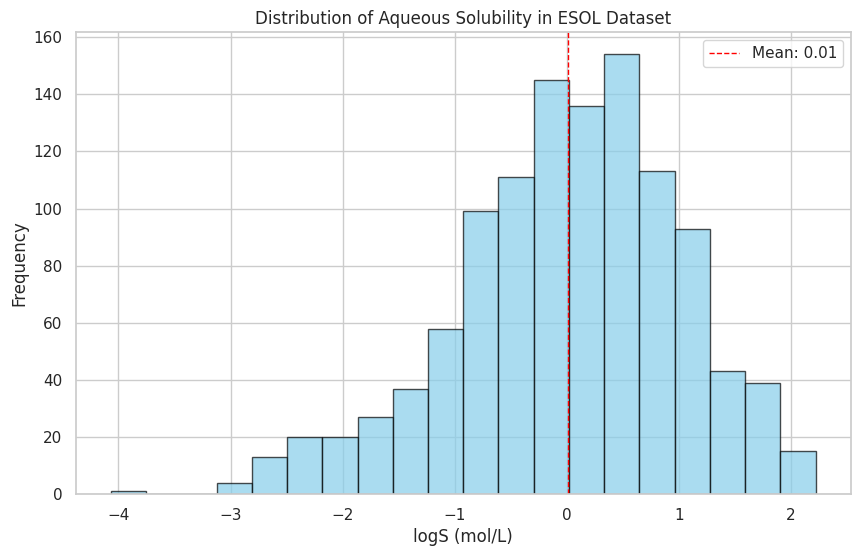

SMILES,Structure,Property
CC(=O)OCC(=O)C3(O)C(CC4C2CCC1=CC(=O)C=CC1(C)C2(F)C(O)CC34C)OC(C)=O,,logS: -0.503
CN(C)c2c(C)n(C)n(c1ccccc1)c2=O,,logS: 1.293
CCOP(=S)(OCC)SC(CCl)N2C(=O)c1ccccc1C2=O,,logS: -1.558
Clc1c(Cl)c(Cl)c(c(Cl)c1Cl)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl,,logS: -4.067
CCCCCBr,,logS: -0.003
Oc1cccc(O)c1,,logS: 1.853
CCCCCCCCCC(C)O,,logS: 0.064
C=CCCC=C,,logS: 0.188
CCOc1ccc(NC(=O)C)cc1,,logS: 0.346
CCC(C)n1c(=O)[nH]c(C)c(Br)c1=O,,logS: 0.263

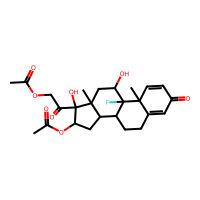
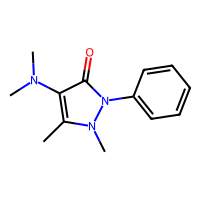
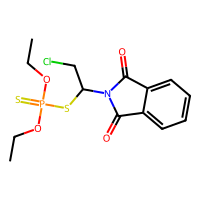
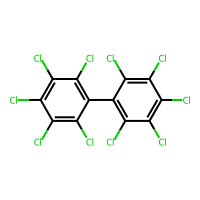
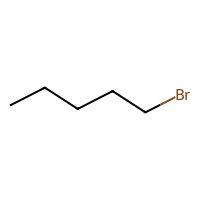
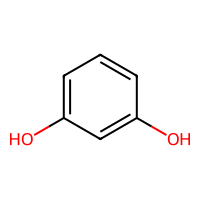
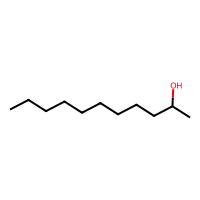
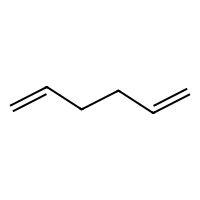
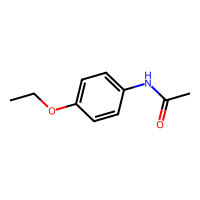
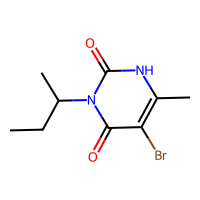

Test MSE (SVR): 0.8613
Test RMSE (SVR): 0.9280


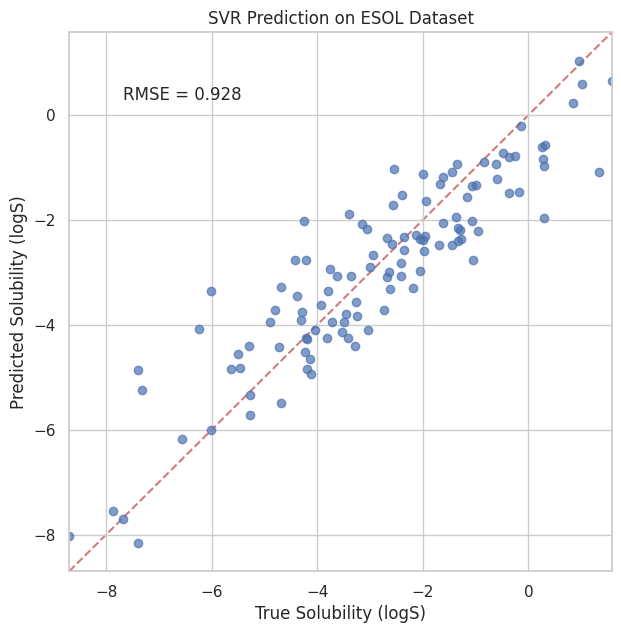

In [5]:
# ================== Basic statistics on logS ==================
y_all_esol = np.concatenate([train_esol_raw.y, valid_esol_raw.y, test_esol_raw.y])
print("\nSolubility (logS) Statistics:")
print(f"Mean: {np.mean(y_all_esol):.2f}")
print(f"Min: {np.min(y_all_esol):.2f}")
print(f"Max: {np.max(y_all_esol):.2f}")
print(f"Std Dev: {np.std(y_all_esol):.2f}")

plt.figure(figsize=(10, 6))
plt.hist(y_all_esol, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(y_all_esol), color='red', linestyle='dashed', linewidth=1,
            label=f'Mean: {np.mean(y_all_esol):.2f}')
plt.xlabel('logS (mol/L)')
plt.ylabel('Frequency')
plt.title('Distribution of Aqueous Solubility in ESOL Dataset')
plt.legend()
plt.show()

# ================== Show some molecules in a table ==================
df_esol = create_molecule_table(train_esol_raw, n=10, label_type='regression', task_name='logS')
try:
    display(HTML(df_esol.to_html(escape=False, index=False)))
except NameError:
    print(df_esol.to_string())

# ================== ECFP Featurization & SVM (SVR) Model ==================
featurizer_esol = CircularFingerprint(radius=2, size=1024)
tasks_esol, datasets_esol, transformers_esol = load_delaney(
    featurizer=featurizer_esol,
    splitter='random',
    transformers=[],
    reload=True
)
train_esol, valid_esol, test_esol = datasets_esol

# SVM regression model (SVR)
svr_esol = SVR(kernel='rbf', C=10.0, epsilon=0.1)   # you can tune these hyperparameters
model_esol = dc.models.SklearnModel(svr_esol)

# Train
model_esol.fit(train_esol)

# Predict
preds_esol = model_esol.predict(test_esol).flatten()
y_true_esol = test_esol.y.flatten()

# Metrics
mse_esol = mean_squared_error(y_true_esol, preds_esol)
rmse_esol = np.sqrt(mse_esol)
print(f"Test MSE (SVR): {mse_esol:.4f}")
print(f"Test RMSE (SVR): {rmse_esol:.4f}")

# Scatter plot: true vs predicted
plt.figure(figsize=(7, 7))
plt.scatter(y_true_esol, preds_esol, alpha=0.7)
plt.xlabel("True Solubility (logS)")
plt.ylabel("Predicted Solubility (logS)")
plt.title("SVR Prediction on ESOL Dataset")
lims = [
    min(np.min(y_true_esol), np.min(preds_esol)),
    max(np.max(y_true_esol), np.max(preds_esol))
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
plt.xlim(lims)
plt.ylim(lims)
plt.grid(True)
plt.text(
    lims[0]*0.9 + lims[1]*0.1,
    lims[1]*0.9 + lims[0]*0.1,
    f'RMSE = {rmse_esol:.3f}',
    ha='left', va='top'
)
plt.show()

In [6]:
# ================== 3D Visualization for first 10 molecules ==================
import py3Dmol
from rdkit.Chem import AllChem

def show_3d_structure(smiles, title="Molecule"):
    try:
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.UFFOptimizeMolecule(mol)
        mb = Chem.MolToMolBlock(mol)

        viewer = py3Dmol.view(width=400, height=300)
        viewer.addModel(mb, "mol")
        viewer.setStyle({'stick': {}})
        viewer.zoomTo()
        display(viewer)

    except Exception as e:
        print(f"Error rendering molecule {smiles}: {e}")

# Loop through first 10 molecules with their logS
for i, smi in enumerate(train_esol_raw.ids[:10]):
    label_val = train_esol_raw.y[i]
    if label_val is not None and hasattr(label_val, '__len__') and len(label_val) > 0:
        prop_str = f"{label_val[0]:.3f}"
    else:
        prop_str = "N/A"

    df_row = pd.DataFrame([[smi, prop_str]], columns=["SMILES", "logS"])
    display(HTML(df_row.to_html(escape=False, index=False)))

    show_3d_structure(smi, title=f"Train molecule #{i+1}")

SMILES,logS
CC(=O)OCC(=O)C3(O)C(CC4C2CCC1=CC(=O)C=CC1(C)C2(F)C(O)CC34C)OC(C)=O,-0.503


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

SMILES,logS
CN(C)c2c(C)n(C)n(c1ccccc1)c2=O,1.293


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

SMILES,logS
CCOP(=S)(OCC)SC(CCl)N2C(=O)c1ccccc1C2=O,-1.558


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

SMILES,logS
Clc1c(Cl)c(Cl)c(c(Cl)c1Cl)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl,-4.067


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

SMILES,logS
CCCCCBr,-0.003


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

SMILES,logS
Oc1cccc(O)c1,1.853


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

SMILES,logS
CCCCCCCCCC(C)O,0.064


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

SMILES,logS
C=CCCC=C,0.188


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

SMILES,logS
CCOc1ccc(NC(=O)C)cc1,0.346


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

SMILES,logS
CCC(C)n1c(=O)[nH]c(C)c(Br)c1=O,0.263


3Dmol.js failed to load for some reason. Please check your browser console for error messages.